In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from bisect import bisect_left
import statsmodels.api as sm
from scipy.stats import hypergeom

# personal modules
import databases as db
import kuzmin_data as data


From the supplement of the Kuzmin et al 2020 paper: "The scoring of 537,911 double and 256,861 triple mutants identified 4,650 negative and 2,547 positive digenic interactions and 2,466 negative and 2,091 positive trigenic interactions."

In [2]:
kuzmin_2020_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2020"
kuzmin_2020_s1, kuzmin_2020_s1_digenic, kuzmin_2020_s1_trigenic = data.load_kuzmin_2020_s1(kuzmin_2020_data_dir)
kuzmin_2020_s3, kuzmin_2020_s3_digenic = data.load_kuzmin_2020_s3(kuzmin_2020_data_dir)
kuzmin_2020_s5, kuzmin_2020_s5_singMut, kuzmin_2020_s5_dblMut = data.load_kuzmin_2020_s5(kuzmin_2020_data_dir)
kuzmin_2020_s2 = data.load_kuzmin_2020_s2(kuzmin_2020_data_dir)


In [2]:
kuzmin_2020_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2020"
kuzmin_2020_s1 = pd.read_csv(f"{kuzmin_2020_data_dir}/aaz5667-Table-S1.txt", sep="\t")
kuzmin_2020_s2 = pd.read_csv(f"{kuzmin_2020_data_dir}/aaz5667-Table-S2.txt", sep="\t")
kuzmin_2020_s3 = pd.read_csv(f"{kuzmin_2020_data_dir}/aaz5667-Table-S3.txt", sep="\t")
kuzmin_2020_s5 = pd.read_csv(f"{kuzmin_2020_data_dir}/aaz5667-Table-S5.txt", sep="\t")


kuzmin_2020_s1 = kuzmin_2020_s1.rename(columns = {"Query strain ID" : "query_strain_id",
                        "Query allele name": "query_allele_name",
                        "Array strain ID": "array_strain_id",
                        "Array allele name": "array_allele_name",
                        "Combined mutant type": "combined_mutant_type",
                        "Raw genetic interaction score (epsilon)": "raw_interaction_score_epsilon",
                        "Adjusted genetic interaction score (epsilon or tau)": "adjusted_interaction_score_epsilon_or_tau",
                        "P-value": "pval",
                        "Query single/double mutant fitness": "query_single_double_mutant_fitness",
                        "Array single mutant fitness": "array_single_mutant_fitness",
                        "Double/triple mutant fitness": "double_triple_mutant_fitness",
                        "Double/triple mutant fitness standard deviation": "double_triple_mutant_fitness_std"})


kuzmin_2020_s1.query_allele_name = kuzmin_2020_s1.query_allele_name.str.replace("_","")
kuzmin_2020_s1.array_allele_name = kuzmin_2020_s1.array_allele_name.str.replace("_","")

kuzmin_2020_s1[['query1_allele_name', 'query2_allele_name']] = kuzmin_2020_s1.query_allele_name.str.split("+", expand=True)
kuzmin_2020_s1['alleles'] = kuzmin_2020_s1[['query1_allele_name', 'query2_allele_name', 'array_allele_name']].agg(','.join, axis=1)

kuzmin_2020_s1_trigenic = kuzmin_2020_s1[kuzmin_2020_s1.combined_mutant_type == 'trigenic'].drop(columns=['combined_mutant_type'])
kuzmin_2020_s1_trigenic = kuzmin_2020_s1_trigenic.reset_index(drop=True)
kuzmin_2020_s1_digenic = kuzmin_2020_s1[kuzmin_2020_s1.combined_mutant_type == 'digenic'].drop(columns=['combined_mutant_type'])
# ho will either be the 1st or second query allele, never the array allele
kuzmin_2020_s1_digenic.alleles = kuzmin_2020_s1_digenic.alleles.str.replace("ho,","")
kuzmin_2020_s1_digenic = kuzmin_2020_s1_digenic.reset_index(drop=True)


kuzmin_2020_s2 = kuzmin_2020_s2.rename(columns = {"Query strain ID" : "query_strain_id",
                        "Query allele name": "query_allele_name",
                        "Array strain ID": "array_strain_id",
                        "Array allele name": "array_allele_name",
                        "Combined mutant type": "combined_mutant_type",
                        "Adjusted genetic interaction score (epsilon or tau)": "adjusted_interaction_score_epsilon_or_tau",
                        "P-value": "pval",
                        "Digenic, Modified trigenic, or Novel trigenic": "digenic_modifiedTrigenic_novelTrigenic"})

kuzmin_2020_s2[['query1_allele_name', 'query2_allele_name']] = kuzmin_2020_s2.query_allele_name.str.split("+", expand=True)
kuzmin_2020_s2['three_alleles'] = kuzmin_2020_s2[['query1_allele_name', 'query2_allele_name', 'array_allele_name']].agg(','.join, axis=1)
kuzmin_2020_s2.three_alleles = kuzmin_2020_s2.three_alleles.str.replace("_","")


# note on s3: query allele fitness for digenic crosses are all NaN, only array allele fitness available
kuzmin_2020_s3 = kuzmin_2020_s3.rename(columns = {"Query strain ID" : "query_strain_id",
                        "Query allele name": "query_allele_name",
                        "Array strain ID": "array_strain_id",
                        "Array allele name": "array_allele_name",
                        "Combined mutant type": "combined_mutant_type",
                        "Raw genetic interaction score (epsilon)": "raw_interaction_score_epsilon",
                        "Adjusted genetic interaction score (epsilon or tau)": "adjusted_interaction_score_epsilon_or_tau",
                        "P-value": "pval",
                        "Query single/double mutant fitness": "query_single_double_mutant_fitness",
                        "Array single mutant fitness": "array_single_mutant_fitness",
                        "Double/triple mutant fitness": "double_triple_mutant_fitness",
                        "Double/triple mutant fitness standard deviation": "double_triple_mutant_fitness_std"})

kuzmin_2020_s3.query_allele_name = kuzmin_2020_s3.query_allele_name.str.replace("_","")
kuzmin_2020_s3.array_allele_name = kuzmin_2020_s3.array_allele_name.str.replace("_","")

kuzmin_2020_s3_digenic = kuzmin_2020_s3[kuzmin_2020_s3.combined_mutant_type == "digenic"]

# S5 table with single and double mutant fitnesses
kuzmin_2020_s5 = kuzmin_2020_s5.rename(columns = {"Allele1" : "allele1",
                                            "Allele2" : "allele2",
                                            "Mutant type" : "mutant_type",
                                            "Fitness" : "fitness",
                                            "St.dev." : "std"})

kuzmin_2020_s5.allele1 = kuzmin_2020_s5.allele1.str.replace("_","")
kuzmin_2020_s5.allele2 = kuzmin_2020_s5.allele2.str.replace("_","")
kuzmin_2020_s5['alleles'] = kuzmin_2020_s5[['allele1', 'allele2']].agg(','.join, axis=1)
kuzmin_2020_s5.alleles = kuzmin_2020_s5.alleles.str.replace("ho,","")
kuzmin_2020_s5.alleles = kuzmin_2020_s5.alleles.str.replace("ho","")

kuzmin_2020_s5_dblMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Double mutant"]
kuzmin_2020_s5_singMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Single mutant"]

print(kuzmin_2020_s1.combined_mutant_type.value_counts())
print(kuzmin_2020_s2.combined_mutant_type.value_counts())
print("summing total digenic from Kuzmin 2020:", 4650+2547)
print("summing total trigenic from Kuzmin 2020:", 2466+2091)


digenic     537911
trigenic    256861
Name: combined_mutant_type, dtype: int64
digenic     7197
trigenic    4557
Name: combined_mutant_type, dtype: int64
summing total digenic from Kuzmin 2020: 7197
summing total trigenic from Kuzmin 2020: 4557


In [3]:
# create dictionaries of fitness/interaction values for quick lookup tables
# these will be used to recompute tau on cumulant and multiplicative scale

kuzmin_2020_s1_dblMutFit = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.double_triple_mutant_fitness))
kuzmin_2020_s1_epsilon = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.raw_interaction_score_epsilon))
kuzmin_2020_s1_singMutFit = dict(zip(kuzmin_2020_s1.array_allele_name, kuzmin_2020_s1.array_single_mutant_fitness))

kuzmin_2020_s3_singMutFit = dict(zip(kuzmin_2020_s3.array_allele_name, kuzmin_2020_s3.array_single_mutant_fitness))

kuzmin_2020_s5_dblMutFit = dict(zip(kuzmin_2020_s5_dblMut.alleles, kuzmin_2020_s5_dblMut.fitness))
kuzmin_2020_s5_singMutFit = dict(zip(kuzmin_2020_s5_singMut.alleles, kuzmin_2020_s5_singMut.fitness))


In [5]:
print(len(kuzmin_2020_s1_digenic))
print(len(kuzmin_2020_s1_digenic.alleles.unique()))

537911
537911


**From the main text**:

Using colony size as a proxy for cell fitness, we measured the growth pheno- types of the set of 240 double-mutant query strains and the corresponding 480 single mu- tants (table S5) (42), which correlated well with previous large-scale measurements of single-mutant fitness (Pearson correlation co- efficient r =0.51, P =3×10−30)

**From the supplement**:

The mean single mutant fitness estimates of each array strain were obtained from a previous study (37).

**Conclusion**:

Double mutants:

- take ij mutants from Kuzmin 2020 S5

- take ik and jk mutants from Kuzmin 2020 S1

Single mutants:

- take i from Kuzmin 2020 S3?????

- take j from Kuzmin 2020 S5

- take k from Kuzmin 2020 S1


Consider three genes i, j, and k. Based on the experimental design of Kuzmin et al, they compute digenic interaction effects between genes i and k (e_ik) and between genes j and k (e_jk). Then, they cross the double mutant ij with single mutant k. This cross introduces 3 interaction effects: 2 digenic (e_ik and e_jk) and 1 trigenic (t_ijk). They compute the trigenic effect by subtracting out the two previously calculated digenic effects. Note that e_ij isn't calculated here and is irrelevant.

For each triple mutant ijk, let's confirm that double mutants ik and jk exist:

In [6]:

f_ij, f_ik, f_jk = defaultdict(), defaultdict(), defaultdict()
f_i, f_j, f_k = defaultdict(), defaultdict(), defaultdict()
e_ik_kuz, e_jk_kuz = defaultdict(), defaultdict()

for i, row in kuzmin_2020_s1_trigenic.iterrows():
    #if i <= 100:
        alleles = row['alleles'].split(",")
        ij = alleles[0] + "," + alleles[1]
        ji = alleles[1] + "," + alleles[0]

        ik = alleles[0] + "," + alleles[2]
        ki = alleles[2] + "," + alleles[0]

        jk = alleles[1] + "," + alleles[2]
        kj = alleles[2] + "," + alleles[1]

        i,j,k = alleles[0], alleles[1], alleles[2]
       
        try:
            f_ij[row['alleles']] = kuzmin_2020_s5_dblMutFit[ij]
        except KeyError:
            try:
                f_ij[row['alleles']] = kuzmin_2020_s5_dblMutFit[ji]
            except:
                f_ij[row['alleles']] = float('nan')
        try:
            f_ik[row['alleles']] = kuzmin_2020_s1_dblMutFit[ik]
        except KeyError:
            try:
                f_ik[row['alleles']] = kuzmin_2020_s1_dblMutFit[ki]
            except:
                f_ik[row['alleles']] = float('nan')
        try:
            f_jk[row['alleles']] = kuzmin_2020_s1_dblMutFit[jk]
        except KeyError:
            try:
                f_jk[row['alleles']] = kuzmin_2020_s1_dblMutFit[kj]
            except:
                f_jk[row['alleles']] = float('nan')
        
        
        # get single mutant fitnesses
        try:
            f_i[row['alleles']] = kuzmin_2020_s3_singMutFit[i]
        except KeyError:
            f_i[row['alleles']] = float('nan')
        try:
            f_j[row['alleles']] = kuzmin_2020_s5_singMutFit[j]
        except KeyError:
            f_j[row['alleles']] = float('nan')  
        try:
            f_k[row['alleles']] = kuzmin_2020_s1_singMutFit[k]
        except KeyError:
            f_k[row['alleles']] = float('nan')      

       
       # get pairwise epistasis
        try:
            e_ik_kuz[row['alleles']] = kuzmin_2020_s1_epsilon[ik]
        except KeyError:
            try:
                e_ik_kuz[row['alleles']] = kuzmin_2020_s1_epsilon[ki]
            except:
                e_ik_kuz[row['alleles']] = float('nan')

        try:
            e_jk_kuz[row['alleles']] = kuzmin_2020_s1_epsilon[jk]
        except KeyError:
            try:
                e_jk_kuz[row['alleles']] = kuzmin_2020_s1_epsilon[kj]
            except:
                e_jk_kuz[row['alleles']] = float('nan')

kuzmin_2020_s1_trigenic['f_ij'] = kuzmin_2020_s1_trigenic['alleles'].map(f_ij)
kuzmin_2020_s1_trigenic['f_ik'] = kuzmin_2020_s1_trigenic['alleles'].map(f_ik)
kuzmin_2020_s1_trigenic['f_jk'] = kuzmin_2020_s1_trigenic['alleles'].map(f_jk)

kuzmin_2020_s1_trigenic['f_i'] = kuzmin_2020_s1_trigenic['alleles'].map(f_i)
kuzmin_2020_s1_trigenic['f_j'] = kuzmin_2020_s1_trigenic['alleles'].map(f_j)
kuzmin_2020_s1_trigenic['f_k'] = kuzmin_2020_s1_trigenic['alleles'].map(f_k)

kuzmin_2020_s1_trigenic['e_ik_kuz'] = kuzmin_2020_s1_trigenic['alleles'].map(e_ik_kuz)
kuzmin_2020_s1_trigenic['e_jk_kuz'] = kuzmin_2020_s1_trigenic['alleles'].map(e_jk_kuz)



In [7]:


print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.f_ij)))
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.f_ik)))
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.f_jk)))
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.f_i)))
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.f_j)))
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.f_k)))
print()
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.e_ik_kuz)))
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.e_jk_kuz)))

#print(len(kuzmin_2020_s1_trigenic.f_ik))
print(len(kuzmin_2020_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])))
print(len(kuzmin_2020_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk'])))
print(len(kuzmin_2020_s1_trigenic))
print(len(kuzmin_2020_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk']))/len(kuzmin_2020_s1_trigenic))

215617
256850
256773
226427
254763
256861

256850
256773
189340
189340
256861
0.7371301988234882


0.9891940424632936
187294


,tau_kuzmin_orig,adjusted_interaction_score_epsilon_or_tau
tau_kuzmin_orig,1.000000,0.997447
adjusted_interaction_score_epsilon_or_tau,0.997447,1.000000


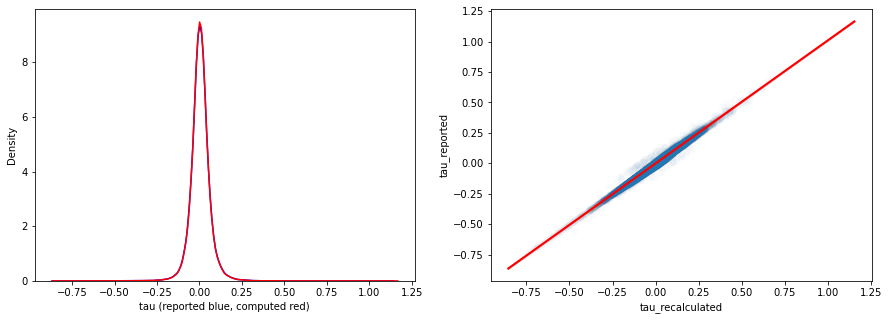

In [8]:
# recalculate tau using the formula in the supplement of Kuzmin 2018

kuzmin_2020_s1_trigenic = kuzmin_2020_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])
threshold = 0.1

df = kuzmin_2020_s1_trigenic
df['tau_kuzmin_orig'] = df.double_triple_mutant_fitness - df.f_ij*df.f_k - df.e_ik_kuz*df.f_j - df.e_jk_kuz*df.f_i
# filter out results that aren't reproducible according to the original equation
print(len(df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold])/len(df))
df = df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold]
print(len(df))

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df['tau_kuzmin_orig'], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, computed red)')

p = sns.regplot(x=df['tau_kuzmin_orig'],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_recalculated', ylabel='tau_reported')

df[['tau_kuzmin_orig', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")


In [9]:
# recalculate tau using isserlis formula
# encountered issue b/c f_jk != (f_j*f_k + e_jk)

# subsituting in f_jk for (f_j*f_k + e_jk) and f_ik for (f_i*f_k + e_ik)
df.loc[:, 'tau_isserlis'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk - df.f_j*df.f_ik - df.f_k*df.f_ij

# calculate multiplicative results
# compare these with tau_isserlis
df.loc[:,'e_ik_mult'] = df.f_ik/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult'] = df.f_jk/(df.f_j*df.f_k)
#df.loc[:,'tau_multiplicative'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult*df.e_jk_mult) 
df.loc[:,'tau_multiplicative'] = (df.double_triple_mutant_fitness*df.f_i*df.f_j*df.f_k)/(df.f_ij*df.f_ik*df.f_jk) 

###########################################################################

# subsituting in (f_j*f_k + e_jk) for f_jk and (f_i*f_k + e_ik) for f_ik
# gives results that are similar to original, see sanityChecks notebook
df.loc[:, 'f_ik_2'] = df.f_i*df.f_k + df.e_ik_kuz
df.loc[:, 'f_jk_2'] = df.f_j*df.f_k + df.e_jk_kuz

df.loc[df['f_ik_2'] < 0, ['f_ik_2']] = np.nan
df.loc[df['f_jk_2'] < 0, ['f_jk_2']] = np.nan

df.loc[:,'e_ik_mult2'] = df.f_ik_2/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult2'] = df.f_jk_2/(df.f_j*df.f_k)

df.loc[:, 'tau_isserlis2'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk_2 - df.f_j*df.f_ik_2 - df.f_k*df.f_ij

# calculate multiplicative results using the custom dbl mutant fitnesses that gave results consistent with those reported (above)
# compare these with tau_isserlis2
#df.loc[:,'tau_multiplicative2'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult2*df.e_jk_mult2) 
df.loc[:,'tau_multiplicative2'] = (df.double_triple_mutant_fitness*df.f_i*df.f_j*df.f_k)/(df.f_ij*df.f_ik_2*df.f_jk_2) 


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
# gene_physical_pairwise_interactions contains a set of sorted 2-tuples of genes particupating in pairwise protein interactions

gene_physical_pairwise_interactions = db.get_physical_interactions_yeastGenomeDotOrg()

# BIOGRID contains physical interactions measured from a variety of assays including co-localization
gene_physical_pairwise_interactions = db.get_physical_interactions_BIOGRID()

num_physical_interactions = {}
oneplus_physical_interactions = {}
twoplus_physical_interactions = {}

for i,r in df.iterrows():
    # alleles in gene_physical_pairwise_interactions are sorted
    alleles = sorted(r['alleles'].split(","))
    alleles = [db.gene_stem_name(i.upper()) for i in alleles]
    allele_pairs = [tuple([alleles[0],alleles[1]]), 
                    tuple([alleles[0],alleles[2]]), 
                    tuple([alleles[1],alleles[2]])]
    num_physical_interactions[r['alleles']] = 0
    oneplus_physical_interactions[r['alleles']] = 0
    twoplus_physical_interactions[r['alleles']] = 0
    for p in allele_pairs:
        if p in gene_physical_pairwise_interactions:
            num_physical_interactions[r['alleles']] += 1
            oneplus_physical_interactions[r['alleles']] = 1
        if num_physical_interactions[r['alleles']] >= 2:
            twoplus_physical_interactions[r['alleles']] = 1

df['num_physical_interactions'] = df['alleles'].map(num_physical_interactions)
df['oneplus_physical_interactions'] = df['alleles'].map(oneplus_physical_interactions)
df['twoplus_physical_interactions'] = df['alleles'].map(twoplus_physical_interactions)
df['num_physical_interactions'].value_counts()


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-10-e90b0986ad64>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_physical_interactions'] = df['alleles'].map(num_physical_interactions)
<ipython-input-10-e90b0986ad64>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

0    143299
1     43063
2       830
3       102
Name: num_physical_interactions, dtype: int64

,tau_isserlis2,adjusted_interaction_score_epsilon_or_tau
tau_isserlis2,1.000000,0.997449
adjusted_interaction_score_epsilon_or_tau,0.997449,1.000000


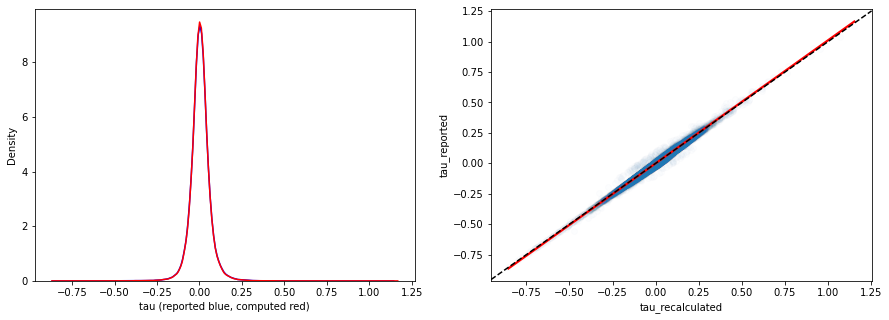

In [11]:
tau = "tau_isserlis2"

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df[tau], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, computed red)')

p = sns.regplot(x=df[tau],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_recalculated', ylabel='tau_reported')
axs[1].axline([-0.75, -0.75], [1, 1], linestyle="--", color="black")

df[[tau, 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")

In [12]:
print("reported mean", np.nanmean(df.adjusted_interaction_score_epsilon_or_tau))
print("multiplicative mean", np.nanmean(df.tau_multiplicative))
print("multiplicative mean, diff dbl mut vals", np.nanmean(df.tau_multiplicative2))

print("###")
print("reported std", np.nanstd(df.adjusted_interaction_score_epsilon_or_tau))
print("multiplicative std", np.nanstd(df.tau_multiplicative))
print("multiplicative std, diff dbl mutant vals", np.nanstd(df.tau_multiplicative2))


reported mean 0.00447713709996049
multiplicative mean 0.9699022075451835
multiplicative mean, diff dbl mut vals 1.0130213672767956
###
reported std 0.05943114514300463
multiplicative std 0.17337197100465504
multiplicative std, diff dbl mutant vals 0.40274533538636875


In [13]:
use_reported_double_mutant_fitnesses = False

if use_reported_double_mutant_fitnesses:
    multiplicative = "tau_multiplicative"
    isserlis = "tau_isserlis"
else:
    multiplicative = "tau_multiplicative2"
    isserlis = "tau_isserlis2"

In [14]:
tau_reported_neg_sig_quant = np.mean( np.array(df.adjusted_interaction_score_epsilon_or_tau) < -0.08)
tau_reported_pos_sig_quant = 1 - np.mean( np.array(df.adjusted_interaction_score_epsilon_or_tau) > 0.08)

print("quantiles of the significant values they used",  tau_reported_neg_sig_quant, tau_reported_pos_sig_quant )
print("confirming (should be -0.08):", np.quantile(df.adjusted_interaction_score_epsilon_or_tau, tau_reported_neg_sig_quant))
print("confirming (should be 0.08):", np.quantile(df.adjusted_interaction_score_epsilon_or_tau, tau_reported_pos_sig_quant))

tau_mult_neg_sig_val = np.nanquantile(df[multiplicative], tau_reported_neg_sig_quant)
tau_mult_pos_sig_val = np.nanquantile(df[multiplicative], tau_reported_pos_sig_quant)

tau_iss_neg_sig_val = np.nanquantile(df[isserlis], tau_reported_neg_sig_quant)
tau_iss_pos_sig_val = np.nanquantile(df[isserlis], tau_reported_pos_sig_quant)

print( "corresponding cutoffs for multiplicative model: ", tau_mult_neg_sig_val, tau_mult_pos_sig_val)
print( "corresponding cutoffs for isserlis model: ", tau_iss_neg_sig_val, tau_iss_pos_sig_val)



quantiles of the significant values they used 0.0505675568891689 0.9305530342669813
confirming (should be -0.08): -0.07998675851335334
confirming (should be 0.08): 0.07998704170448599
corresponding cutoffs for multiplicative model:  0.9051323011432824 1.1071547776828774
corresponding cutoffs for isserlis model:  -0.07906997897906282 0.07887639643511797


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


                     tau_multiplicative2  tau_isserlis2
tau_multiplicative2             1.000000       0.985584
tau_isserlis2                   0.985584       1.000000
                     tau_multiplicative2  tau_isserlis2
tau_multiplicative2             1.000000       0.919664
tau_isserlis2                   0.919664       1.000000
                     tau_multiplicative2  tau_isserlis2
tau_multiplicative2             1.000000       0.250573
tau_isserlis2                   0.250573       1.000000


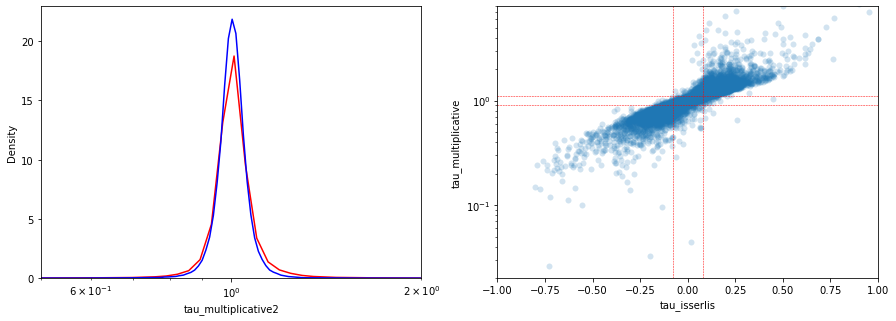

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

bw_param =10
p = sns.kdeplot(df[multiplicative], ax = axs[0], color="red", log_scale=True)
p = sns.kdeplot(df[isserlis]+1, ax = axs[0], color="blue")
axs[0].set_xlim(0.5,2)

p = sns.scatterplot(x=df[isserlis],
            y=df[multiplicative],
            alpha=0.2,
            linewidth=0,
            ax=axs[1])
p.set(xlabel='tau_isserlis', ylabel='tau_multiplicative')
axs[1].set_xlim(-1,1)
axs[1].set_yscale('log')
axs[1].set_ylim(0.02,8)
axs[1].axhline(tau_mult_neg_sig_val, color="red", linestyle="--", linewidth=0.5)
axs[1].axhline(tau_mult_pos_sig_val, color="red", linestyle="--", linewidth=0.5)
axs[1].axvline(-0.08, color="red", linestyle="--", linewidth=0.5)
axs[1].axvline(0.08, color="red", linestyle="--", linewidth=0.5)

"""p = sns.scatterplot(x=np.sort(df[isserlis])+1,
                    y=np.sort(df[multiplicative]),
                    ax = axs[2])
p.set(xlabel='tau_isserlis', ylabel='tau_multiplicative')
axs[2].set(xscale="log", yscale="log")                    
axs[2].set_ylim(0.01,100)"""

print(df[[multiplicative, isserlis]].corr(method="spearman"))
print(df[[multiplicative, isserlis]].corr(method="kendall"))
print(df[[multiplicative, isserlis]].corr(method="pearson"))


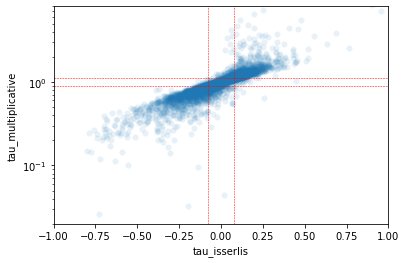

In [16]:
p = sns.scatterplot(x=df[isserlis][df.pval < 0.05],
            y=df[multiplicative][df.pval < 0.05],
            alpha=0.1,
            linewidth=0)
p.set(xlabel='tau_isserlis', ylabel='tau_multiplicative')
p.set_xlim(-1,1)
p.set_yscale('log')
p.set_ylim(0.02,8)
p.axhline(tau_mult_neg_sig_val, color="red", linestyle="--", linewidth=0.5)
p.axhline(tau_mult_pos_sig_val, color="red", linestyle="--", linewidth=0.5)
p.axvline(-0.08, color="red", linestyle="--", linewidth=0.5)
p.axvline(0.08, color="red", linestyle="--", linewidth=0.5)

In [17]:
# how many significant trigenic results on multiplicative and isserlis scale

df_sig = df[df.pval < 0.05]

df_pos_sig_reported = df_sig[df_sig.adjusted_interaction_score_epsilon_or_tau > 0.08]
df_neg_sig_reported = df_sig[df_sig.adjusted_interaction_score_epsilon_or_tau < -0.08]

df_pos_sig_mult = df_sig[df_sig[multiplicative] > tau_mult_pos_sig_val]
df_neg_sig_mult = df_sig[df_sig[multiplicative] < tau_mult_neg_sig_val]

# NOTE: if you use the reported dbl mutant values which may not have been corrected for batch effects, then 
# then there is a huge negative skew of trigenic scores, such that using the same significance cutoff of +/- 0.08
# leads to many falsely significant negative trigenic scores
#df_pos_sig_iss = df_sig[df_sig[isserlis] > tau_iss_pos_sig_val]
#df_neg_sig_iss = df_sig[df_sig[isserlis] < tau_iss_neg_sig_val]
df_pos_sig_iss = df_sig[df_sig[isserlis] > 0.08]
df_neg_sig_iss = df_sig[df_sig[isserlis] < -0.08]

print("positive and negative interactions in original data")
print("pos: ", len(df_pos_sig_reported))
print("neg: ", len(df_neg_sig_reported))

print("positive and negative interactions on multiplciative scale")
print("pos: ",len(df_pos_sig_mult))
print("neg: ",len(df_neg_sig_mult))

print("positive and negative interactions on isserlis scale")
print("pos: ",len(df_pos_sig_iss))
print("neg: ",len(df_neg_sig_iss))


positive and negative interactions in original data
pos:  1328
neg:  1618
positive and negative interactions on multiplciative scale
pos:  1456
neg:  2003
positive and negative interactions on isserlis scale
pos:  1286
neg:  1614


In [18]:
# IF YOU USE THE REPORTED DOUBLE MUTANT VALUES, SCORES RECALCULATED WITH MULTIPLICATIVE OR ISSERLIS FORMULA 
# WILL DIFFER FROM THE REPORTED VALUES
# in this case, use method_ground_truth = "isserlis" and method_to_compare = "multiplicative"
# otherwise, if you calculate double mutant fitness as f_i*f_j + e_ij, you can compare isserlis or multiplciative with reported

"""
method_ground_truth = "reported" # isserlis or reported significant values
method_to_compare = "multiplicative" # compare isserlis or multiplicative with reported significant values

assert method_to_compare == "isserlis" or method_to_compare == "multiplicative"
assert method_ground_truth == "isserlis" or method_ground_truth == "reported"

if method_to_compare == "isserlis":
    tmp_pos = df_pos_sig_reported.merge(df_pos_sig_iss, how="outer", on="alleles")
    tmp_neg = df_neg_sig_reported.merge(df_neg_sig_iss, how="outer", on="alleles")
elif method_to_compare == "multiplicative":
    if method_ground_truth == "reported":
        tmp_pos = df_pos_sig_reported.merge(df_pos_sig_mult, how="outer", on="alleles")
        tmp_neg = df_neg_sig_reported.merge(df_neg_sig_mult, how="outer", on="alleles")
    else:
        tmp_pos = df_pos_sig_iss.merge(df_pos_sig_mult, how="outer", on="alleles")
        tmp_neg = df_neg_sig_iss.merge(df_neg_sig_mult, how="outer", on="alleles")
"""

def outlier_comparison(df_sig):
    results = defaultdict(int)
    results_frac = defaultdict(float)

    cond = (df_sig.adjusted_interaction_score_epsilon_or_tau > 0.08) & (df_sig[multiplicative] > tau_mult_pos_sig_val)
    results['both positive'] = len(df_sig[cond])
    cond = (df_sig.adjusted_interaction_score_epsilon_or_tau > 0.08) & (df_sig[multiplicative] < tau_mult_pos_sig_val)
    results['only reported positive'] = len(df_sig[cond])
    cond = (df_sig.adjusted_interaction_score_epsilon_or_tau < 0.08) & (df_sig[multiplicative] > tau_mult_pos_sig_val)
    results[f'only mult positive'] =  len(df_sig[cond])

    cond = (df_sig.adjusted_interaction_score_epsilon_or_tau < -0.08) & (df_sig[multiplicative] < tau_mult_neg_sig_val)
    results['both negative'] = len(df_sig[cond])
    cond = (df_sig.adjusted_interaction_score_epsilon_or_tau < -0.08) & (df_sig[multiplicative] > tau_mult_neg_sig_val)
    results['only reported negative'] = len(df_sig[cond])
    cond = (df_sig.adjusted_interaction_score_epsilon_or_tau > -0.08) & (df_sig[multiplicative] < tau_mult_neg_sig_val)
    results[f'only mult negative'] = len(df_sig[cond])

    pos_denom = results['both positive'] + results['only reported positive'] + results[f'only mult positive']
    neg_denom = results['both negative'] + results['only reported negative'] + results[f'only mult negative']

    results_frac['both positive'] = results['both positive']/pos_denom
    results_frac['only reported positive'] = results['only reported positive']/pos_denom
    results_frac[f'only mult positive'] = results[f'only mult positive']/pos_denom

    results_frac['both negative'] = results['both negative']/neg_denom
    results_frac['only reported negative'] = results['only reported negative']/neg_denom
    results_frac[f'only mult negative'] = results[f'only mult negative']/neg_denom

    return results, results_frac

results, results_frac = outlier_comparison(df_sig)

tmp = pd.DataFrame.from_dict(results, orient='index')
tmp = tmp.rename(columns = {0:"number"})
tmp['frac'] = tmp.index.map(results_frac)
tmp

,number,frac
both positive,1197,0.756637
only reported positive,126,0.079646
only mult positive,259,0.163717
both negative,1527,0.729226
only reported negative,91,0.043457
only mult negative,476,0.227316


In [19]:
def fraction_physical_twoplus(df):
    """
    Returns a dict of the number of gene triplets with 2+ physical interactions along with the total number of triplets
    """
    d = {}
    d['tot'] = len(df.twoplus_physical_interactions)
    d['int'] = np.sum(df.twoplus_physical_interactions)
    d['frac'] = d['int']/d['tot']
    return d

def compare_outlier_enrichment(sign, func):
    """
    This function then passes a subselection of outliers to some external function,
    categorizing outliers as significant for both cumulant and multiplicative scale, only cumulant (reported), or only multiplicative.
    The selection of data depends on whether you're interested in negative or positive outliers.
    """
    if sign == "positive":
        both = func(df_sig[(df_sig.adjusted_interaction_score_epsilon_or_tau > 0.08) & (df_sig[multiplicative] > tau_mult_pos_sig_val)])
        only_reported = func(df_sig[(df_sig.adjusted_interaction_score_epsilon_or_tau > 0.08) & (df_sig[multiplicative] < tau_mult_pos_sig_val)])
        only_mult = func(df_sig[(df_sig.adjusted_interaction_score_epsilon_or_tau < 0.08) & (df_sig[multiplicative] > tau_mult_pos_sig_val)])
    elif sign == "negative":
        both = func(df_sig[(df_sig.adjusted_interaction_score_epsilon_or_tau < -0.08) & (df_sig[multiplicative] < tau_mult_neg_sig_val)])
        only_reported = func(df_sig[(df_sig.adjusted_interaction_score_epsilon_or_tau < -0.08) & (df_sig[multiplicative] > tau_mult_neg_sig_val)])
        only_mult = func(df_sig[(df_sig.adjusted_interaction_score_epsilon_or_tau > -0.08) & (df_sig[multiplicative] < tau_mult_neg_sig_val)])   

    return both, only_reported, only_mult

def mk_barplot(genome_wide, both, only_reported, only_mult, i):
    bars = ('genome_wide', 'both', 'only_reported', 'only_mult')
    x_pos = np.arange(len(bars))
    height = [genome_wide, both, only_reported, only_mult]
    axs[i].bar(x_pos, height)
    axs[i].xaxis.set_ticks([])
   



([<matplotlib.axis.XTick at 0x7f9008e28b80>,
 [Text(0, 0, 'genome_wide'),
  Text(1, 0, 'both'),
  Text(2, 0, 'only_reported'),
  Text(3, 0, 'only_mult')])

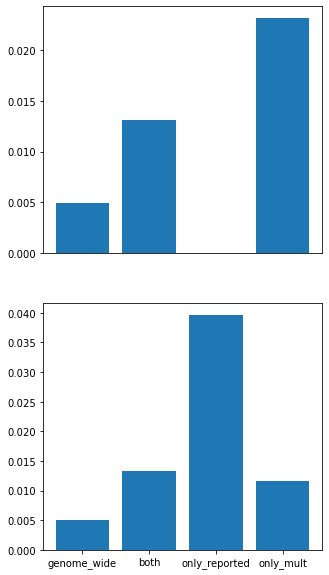

In [20]:
fig, axs = plt.subplots(nrows=2, figsize=(5,10))

genome_wide = fraction_physical_twoplus(df)

both, only_reported, only_mult = compare_outlier_enrichment("negative", fraction_physical_twoplus)
mk_barplot(genome_wide['frac'], both['frac'], only_reported['frac'], only_mult['frac'], 0)

both, only_reported, only_mult = compare_outlier_enrichment("positive", fraction_physical_twoplus)
mk_barplot(genome_wide['frac'], both['frac'], only_reported['frac'], only_mult['frac'], 1)

bars = ('genome_wide', 'both', 'only_reported', 'only_mult')
x_pos = np.arange(len(bars))
plt.xticks(x_pos, bars)


Hypergeometric distribution parameters according to Wikipedia (with scipy.stats hypergeom parameters in parentheses)

N (M) is the population size,

K (n) is the number of success states in the population,

n (N) is the number of draws (i.e. quantity drawn in each trial),

k (k) is the number of observed successes,

hypergeom.cdf(k, M, n, N, loc=0)

In [21]:
def get_hypergeom_params(sample, population):
    """
    Returns parameters for hypergeom.cdf in a list [k, M, n, N]
    """
    return [sample['int'], population['tot'], population['int'], sample['tot']]

def perform_hypergeom_test(sign, func):
    """
    This function automates using hypergeom.cdf for both positive and negative outliers, specified by 'sign' parameter.
    The 'func' parameter is used to categories gene triplets by physical interactions or GO categories
    """
    genome_wide = func(df)
    both, only_reported, only_mult = compare_outlier_enrichment(sign, func)
    # since we are looking for positive enrichments above population baseline, take 1 - CDF(x)
    both_htest = 1-hypergeom.cdf(*get_hypergeom_params(both, genome_wide))
    only_reported_htest = 1-hypergeom.cdf(*get_hypergeom_params(only_reported, genome_wide))
    only_mult_htest = 1-hypergeom.cdf(*get_hypergeom_params(only_mult, genome_wide))

    return both_htest, only_reported_htest, only_mult_htest


print(perform_hypergeom_test("negative", fraction_physical_twoplus))
print(perform_hypergeom_test("positive", fraction_physical_twoplus))

(3.987612577716071e-05, 0.3649604315187549, 6.480995874413864e-06)
(0.00014385441992037507, 4.432209096805195e-05, 0.04145206201679885)


In [22]:
# gene_2_go is a dict of lists where keys are gene names, values are lists of GO categories
gene_2_go = db.get_go_info()

def alleles_2_go_enrichment(df):
    """
    This function calculates number of instances in which all three genes belong to the same GO category,
    specified as 'int' key (short for interaction) of a dict
    """
    d = {}
    #go_hit_2plus = 0
    go_hit_3x = 0
    for i,r in df.iterrows():
        alleles = sorted(r['alleles'].split(","))
        alleles = [db.gene_stem_name(i.upper()) for i in alleles]

        go_counts = defaultdict(int)
        for a in alleles:
            if a in gene_2_go:
                # many genes are involved in many GO categories; iterate through these
                for g in gene_2_go[a]:
                    go_counts[g] += 1
    
        counts = np.array([i[1] for i in go_counts.items()])
        #print(np.max(counts))
        if len(counts) > 0:
            assert np.max(counts) <= 3
        #if np.sum(np.any(counts > 1)):
        #    go_hit_2plus += 1
        if np.sum(np.any(counts == 3)):
            go_hit_3x += 1

    d['tot'] = len(df)
    d['int'] = go_hit_3x
    d['frac'] = d['int']/d['tot'] 
    return d
   

([<matplotlib.axis.XTick at 0x7f9008340c40>,
 [Text(0, 0, 'genome_wide'),
  Text(1, 0, 'both'),
  Text(2, 0, 'only_reported'),
  Text(3, 0, 'only_mult')])

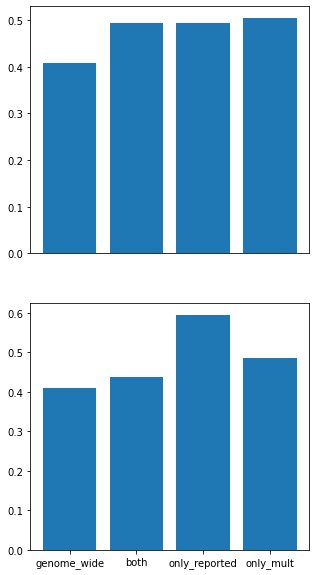

In [23]:
genome_wide = alleles_2_go_enrichment(df)

fig, axs = plt.subplots(nrows=2, figsize=(5,10))

both, only_reported, only_mult = compare_outlier_enrichment("negative", alleles_2_go_enrichment)
mk_barplot(genome_wide['frac'], both['frac'], only_reported['frac'], only_mult['frac'], 0)

both, only_reported, only_mult = compare_outlier_enrichment("positive", alleles_2_go_enrichment)
mk_barplot(genome_wide['frac'], both['frac'], only_reported['frac'], only_mult['frac'], 1)

plt.xticks(x_pos, bars)

In [24]:
print(perform_hypergeom_test("negative", alleles_2_go_enrichment))

(4.4383940966952196e-11, 0.039215100805913505, 1.0675693422279586e-05)


In [25]:
print(perform_hypergeom_test("positive", alleles_2_go_enrichment))

(0.019300391347821688, 8.434250558075895e-06, 0.004786552297971203)


In [26]:
# look at gene triplets for different multiplicative outliers not reported as significant; inspect as jupyter variables in VS code
x1 = sorted(df_sig.alleles[(df_sig.adjusted_interaction_score_epsilon_or_tau < 0.08) & (df_sig[multiplicative] > tau_mult_pos_sig_val)])
x2 = sorted(df_sig.alleles[(df_sig.adjusted_interaction_score_epsilon_or_tau > -0.08) & (df_sig[multiplicative] < tau_mult_neg_sig_val)])
x3 = sorted(df_sig.alleles[(df_sig.adjusted_interaction_score_epsilon_or_tau < -0.08) & (df_sig[multiplicative] > tau_mult_neg_sig_val)])

In [27]:
test = pd.read_csv("/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2020/aaz5667-Table-S8.txt", sep="\t", encoding = "ISO-8859-1")
test

,DM strainID,SM1 strainID,SM2 strainID,ORF1,ORF2,Gene1,Gene2,Ohnolog (A-A) or Homeolog (A-AB)
0,tm143,tm405,tm2305,YBR014C,YDL010W,GRX7,GRX6,A - AB
1,tm164,tm550,tm2249,YLL012W,YLR020C,YEH1,YEH2,A - AB
2,tm1509,tm651,tm362,YHR001W,YKR003W,OSH7,OSH6,A - AB
3,tm3397,tm697,tm2295,YGR243W,YHR162W,MPC3,MPC2,A - AB
4,tm170,tm468,tm1283,YJR091C,YPR042C,JSN1,PUF2,A - AB
...,...,...,...,...,...,...,...,...
235,tm108,tm596,tm1150,YMR222C,YOR280C,FSH2,FSH3,NaN
236,tm1554,tm1861,tm1805,YAL051W,YOR363C,OAF1,PIP2,NaN
237,tm1616,tm576,tm1207,YGL082W,YPL191C,YGL082W,YPL191C,NaN
238,tm95,tm448,tm1137,YMR175W,YPL223C,SIP18,GRE1,NaN


NameError: name 'tmp_pos' is not defined

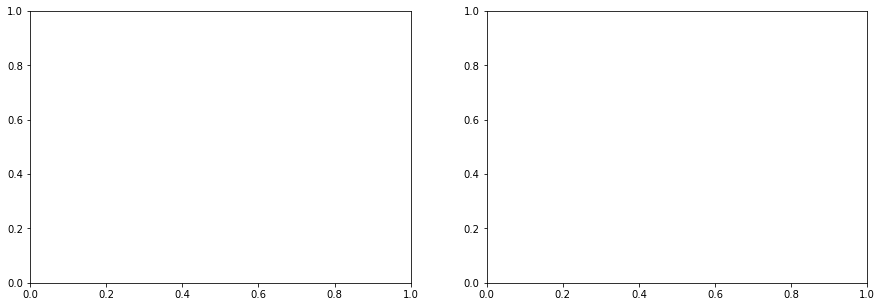

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

pos_multiplicative_alleles = tmp_pos.alleles[(tmp_pos.array_allele_name_x.isna()) & (tmp_pos.array_allele_name_y.notna())]
tmp = df.loc[df['alleles'].isin(pos_multiplicative_alleles)]

p = sns.scatterplot(x=tmp[isserlis],
            y=tmp[multiplicative],
            alpha=0.3,
            linewidth=0,
            ax=axs[0])
axs[0].set(xlabel='tau_cumulant', ylabel='tau_multiplicative')
#p.set_xlim(-1,1)
axs[0].set_yscale('log')
#p.set_ylim(0.02,8)
axs[0].axhline(tau_mult_neg_sig_val, color="red", linestyle="--", linewidth=0.5)
axs[0].axhline(tau_mult_pos_sig_val, color="red", linestyle="--", linewidth=0.5)
axs[0].axvline(-0.08, color="red", linestyle="--", linewidth=0.5)
axs[0].axvline(0.08, color="red", linestyle="--", linewidth=0.5)
axs[0].axvline(0.0, color="black", linestyle="--", linewidth=0.5)

neg_multiplicative_alleles = tmp_neg.alleles[(tmp_neg.array_allele_name_x.isna()) & (tmp_neg.array_allele_name_y.notna())]
tmp = df.loc[df['alleles'].isin(neg_multiplicative_alleles)]

p = sns.scatterplot(x=tmp[isserlis],
            y=tmp[multiplicative],
            alpha=0.3,
            linewidth=0,
            ax=axs[1])
axs[1].set(xlabel='tau_cumulant', ylabel='tau_multiplicative')
#p.set_xlim(-1,1)
axs[1].set_yscale('log')
#p.set_ylim(0.02,8)
axs[1].axhline(tau_mult_neg_sig_val, color="red", linestyle="--", linewidth=0.5)
axs[1].axhline(tau_mult_pos_sig_val, color="red", linestyle="--", linewidth=0.5)
axs[1].axvline(-0.08, color="red", linestyle="--", linewidth=0.5)
axs[1].axvline(0.08, color="red", linestyle="--", linewidth=0.5)
axs[1].axvline(0.0, color="black", linestyle="--", linewidth=0.5)


<AxesSubplot:xlabel='adjusted_interaction_score_epsilon_or_tau', ylabel='Density'>

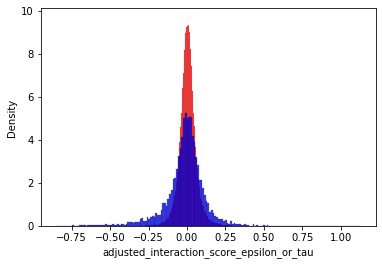

In [ ]:
sns.histplot(df.adjusted_interaction_score_epsilon_or_tau, color="red", stat="density")
sns.histplot(df_sig.adjusted_interaction_score_epsilon_or_tau, color="blue", stat="density")

1.0657718662406535
0.9626505926200865
2.475594397354814


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


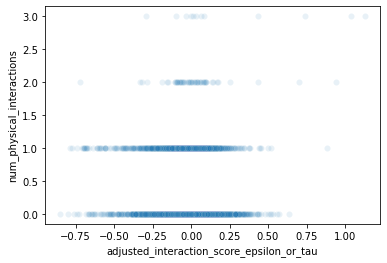

In [ ]:

p = sns.scatterplot(df_sig.adjusted_interaction_score_epsilon_or_tau,df_sig.num_physical_interactions, alpha=0.1)


#tmp = "adjusted_interaction_score_epsilon_or_tau"
tmp = multiplicative

#print(np.nanmean( df_sig[tmp][(df_sig[tmp] > 0) & (df_sig.oneplus_physical_interactions == 0)] ))
#print(np.nanmean( df_sig[tmp][(df_sig[tmp] > 0) & (df_sig.oneplus_physical_interactions == 1)] ))

print(np.nanmean( df_sig[tmp][ df_sig.num_physical_interactions == 0] ))
print(np.nanmean( df_sig[tmp][ df_sig.num_physical_interactions == 1] ))
print(np.nanmean( df_sig[tmp][ df_sig.num_physical_interactions >= 2] ))

#print(np.nanmedian(df_sig.adjusted_interaction_score_epsilon_or_tau[df_sig.oneplus_physical_interactions == 0]))
#print(np.nanmedian(df_sig.adjusted_interaction_score_epsilon_or_tau[df_sig.oneplus_physical_interactions == 1]))

#print(np.nanmedian(df_sig[multiplicative][df_sig.oneplus_physical_interactions == 0]))
#print(np.nanmedian(df_sig[multiplicative][df_sig.oneplus_physical_interactions == 1]))

In [ ]:
#tmp = "adjusted_interaction_score_epsilon_or_tau"
tmp = multiplicative

subset = df_sig[tmp].notna()

X = np.array(df_sig[tmp][subset]).reshape(-1,1)
Y = df_sig.twoplus_physical_interactions[subset]
print(len(X))

res = LogisticRegression(random_state=0).fit(np.log(X), Y)
print(res.coef_)
print(res.intercept_)

7957


<ipython-input-56-e55ec59d5644>:10: RuntimeWarning: invalid value encountered in log
  res = LogisticRegression(random_state=0).fit(np.log(X), Y)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
np.log(X)

<ipython-input-55-1ce7a68dd2e6>:1: RuntimeWarning: invalid value encountered in log
  np.log(X)


array([[-0.02488511],
       [-0.05874193],
       [ 0.15539719],
       ...,
       [ 0.15232418],
       [-0.01888488],
       [-0.43202115]])

In [ ]:
neg_multiplicative_alleles = tmp_neg.alleles[(tmp_neg.array_allele_name_x.isna()) & (tmp_neg.array_allele_name_y.notna())]
tmp = df.loc[df['alleles'].isin(neg_multiplicative_alleles)]

x = tmp[(tmp.adjusted_interaction_score_epsilon_or_tau>0.00)][["alleles", "adjusted_interaction_score_epsilon_or_tau", isserlis, multiplicative]].sort_values(by="alleles")
x.tail(30)


,alleles,adjusted_interaction_score_epsilon_or_tau,tau_isserlis2,tau_multiplicative2
5529,"gpb2,gpb1,sse1",0.028460,0.021538,0.665096
4919,"gpb2,gpb1,yor1",0.005877,-0.028110,0.836707
40512,"kcc4,gin4,nbp2",0.089002,0.082251,0.904207
244756,"kin4,frk1,sac1",0.000649,-0.009849,0.787189
202370,"mlp1,mlp2,swr1",0.007475,0.011040,0.899984
232423,"msg5,sdp1,pmr1",0.010977,0.008417,0.899355
48504,"npp1,npp2,clg1",0.097607,0.073630,0.866068
48580,"npp1,npp2,rpn1-821",0.009683,-0.001547,0.806872
223090,"nup53,asm4,BET3-ph",0.000562,0.004658,0.726107
222628,"nup53,asm4,TRS23-PH",0.059092,0.065270,0.563035


In [ ]:
pos_multiplicative_alleles = tmp_pos.alleles[(tmp_pos.array_allele_name_x.isna()) & (tmp_pos.array_allele_name_y.notna())]
tmp = df.loc[df['alleles'].isin(pos_multiplicative_alleles)]

tmp[(tmp.adjusted_interaction_score_epsilon_or_tau<0.00)][["alleles", "adjusted_interaction_score_epsilon_or_tau", isserlis, multiplicative]].sort_values(by="alleles")


,alleles,adjusted_interaction_score_epsilon_or_tau,tau_isserlis2,tau_multiplicative2
49814,"are1,are2,bck1",-0.014766,-0.013266,1.110828
50274,"are1,are2,chl1",-0.017532,-0.015424,1.206408
50260,"are1,are2,myo2-14",-0.021713,-0.020670,1.133033
49818,"are1,are2,pam16-3",-0.002152,-0.001603,1.114013
49968,"are1,are2,sed5-1",-0.049710,-0.050641,1.130057
227988,"cik1,vik1,sup35-td",-0.025101,0.020738,75.337056
91961,"heh2,src1,pom34",-0.015177,-0.019067,1.108816
91486,"heh2,src1,sac3",-0.021025,-0.019787,1.246198
91355,"heh2,src1,sec66",-0.028749,-0.031521,1.255338
130541,"lsb1,pin3,cog3-1",-0.056894,-0.023561,1.173636


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


                       tau_isserlis2_x  tau_multiplicative2_y
tau_isserlis2_x               1.000000               0.702297
tau_multiplicative2_y         0.702297               1.000000
                       tau_isserlis2_x  tau_multiplicative2_y
tau_isserlis2_x               1.000000               0.156976
tau_multiplicative2_y         0.156976               1.000000


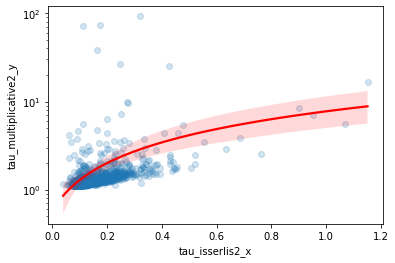

In [ ]:
tmp = tmp_pos[(tmp_pos.array_allele_name_x.notna()) & (tmp_pos.array_allele_name_y.notna())] 
p = sns.regplot(tmp[f'{isserlis}_x'],
            tmp[f'{multiplicative}_y'],
            scatter_kws={'alpha':0.2},
            line_kws={'color': 'red'})
p.set(yscale="log")
print(tmp[[f'{isserlis}_x', f'{multiplicative}_y']].corr(method="spearman"))
print(tmp[[f'{isserlis}_x', f'{multiplicative}_y']].corr(method="pearson"))


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


                       tau_isserlis2_x  tau_multiplicative2_y
tau_isserlis2_x               1.000000               0.805207
tau_multiplicative2_y         0.805207               1.000000
                       tau_isserlis2_x  tau_multiplicative2_y
tau_isserlis2_x               1.000000               0.810863
tau_multiplicative2_y         0.810863               1.000000


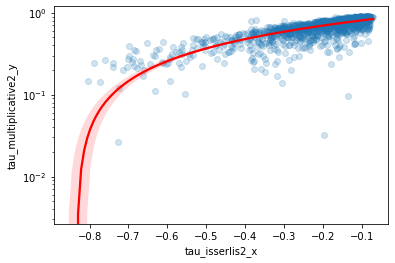

In [ ]:
tmp = tmp_neg[(tmp_neg.array_allele_name_x.notna()) & (tmp_neg.array_allele_name_y.notna())] 
p = sns.regplot(tmp[f'{isserlis}_x'],
            tmp[f'{multiplicative}_y'],
            scatter_kws={'alpha':0.2},
            line_kws={'color': 'red'})
p.set(yscale="log")
print(tmp[[f'{isserlis}_x', f'{multiplicative}_y']].corr(method="spearman"))
print(tmp[[f'{isserlis}_x', f'{multiplicative}_y']].corr(method="pearson"))
